In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
#### Espaço celular 
##### knowledge susceptible  (S) = 0
##### knowledge contactor    (E) = 1
##### knowledge disseminator (I) = 2
##### knowledge forgetter    (R) = 3
##### knowledge quitter      (Q) = 4

In [49]:
#### DEFINI OS VALORES DAS VARIÁVEIS INICIAIS
def set_up_configuration(normalize=(0,0.25),distribution_type='random'):
    rows, cols = 20, 20
    # Parametros para função de mobilidade
    min_rate = normalize[0]
    max_rate = normalize[1] # Tipo de normalização - cenário 1 = N(0,0.25) do artigo seção 4.4

    n_cells = rows * cols  
    rows_grid, cols_grid = np.mgrid[0:rows, 0:cols]  # Gera um grid
    row_indices = rows_grid.flatten()  # Transforma em array 1D [0, 0, ..., 19, 19]
    col_indices = cols_grid.flatten()  

    pop_status = np.zeros(n_cells, dtype=int)   ## inicia toda a população com status = 0 (S)
    disseminators = n_cells * 5 // 100  # 95% da populacao é S e 5% é I 

    if distribution_type == 'monopolistic':
        center_r, center_c = 17, 10 ##rows // 2, cols // 2
        count = 0
        for r_offset in range(-3, 2):
            for c_offset in range(-3, 2):
                if count < disseminators and -1 < (center_r + r_offset) < rows and -1 < (center_c + c_offset) < cols:
                    idx = (center_r + r_offset) * cols + (center_c + c_offset)
                    pop_status[idx] = 2
                    count += 1
    elif distribution_type == 'small-group':
        coords = [(3, 3), (3, 15), (10, 4), (13, 15), (18,0)]
        count = 0
        for gr, gc in coords:
            for r_offset in range(2):
                for c_offset in range(2):
                     if count < disseminators:
                        idx = (gr + r_offset) * cols + (gc + c_offset)
                        if idx < len(pop_status) and pop_status[idx] == 0:
                            pop_status[idx] = 2
                            count += 1
    else: # 'random'
        pop_status[:disseminators] = 2
        np.random.shuffle(pop_status)

    # Estados possíveis 0=S, 1=E, 2=I, 3=R, 4=Q 
    # Cria o dataframe com a população e seus Parametros individuais
    data = {
        'row': row_indices,
        'col' : col_indices,
        'status': pop_status,
        'learningCapability': np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_cells)),
        'transferCapability': np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_cells)),
        'forgettingRate': np.random.uniform(min_rate, max_rate, n_cells), 
        'quittingRate': np.random.uniform(min_rate, max_rate, n_cells), 
        'timesContactor': np.zeros(n_cells).astype(int)
    }
    name_cols = ['row', 'col','status', 'learningCapability', 'transferCapability','forgettingRate', 'quittingRate', 'timesContactor']

    # Create DataFrame
    df = pd.DataFrame(data, columns=name_cols)
    return (df)

In [3]:
# Testar 
tipos=['random','monopolistic','small-group']
for i in range(3):
    cellularGrid = set_up_configuration(distribution_type = tipos[i])  
    # Verify the shape and status distribution
    print(f'------------- Tipo: {tipos[i]}')
    print("DataFrame shape:", cellularGrid.shape)
    print("Status distribution:")
    print(cellularGrid['status'].value_counts())

print(cellularGrid.head())

------------- Tipo: random
DataFrame shape: (400, 8)
Status distribution:
status
0    380
2     20
Name: count, dtype: int64
------------- Tipo: monopolistic
DataFrame shape: (400, 8)
Status distribution:
status
0    380
2     20
Name: count, dtype: int64
------------- Tipo: small-group
DataFrame shape: (400, 8)
Status distribution:
status
0    380
2     20
Name: count, dtype: int64
   row  col  status  learningCapability  transferCapability  forgettingRate  \
0    0    0       0            1.624345            1.306534        0.187927   
1    0    1       0            0.611756            0.076380        0.190658   
2    0    2       0            0.528172            0.367232        0.117370   
3    0    3       0            1.072969            1.232899        0.052691   
4    0    4       0            0.865408            0.422857        0.010369   

   quittingRate  timesContactor  
0      0.177589               0  
1      0.113911               0  
2      0.151303               0  
3  

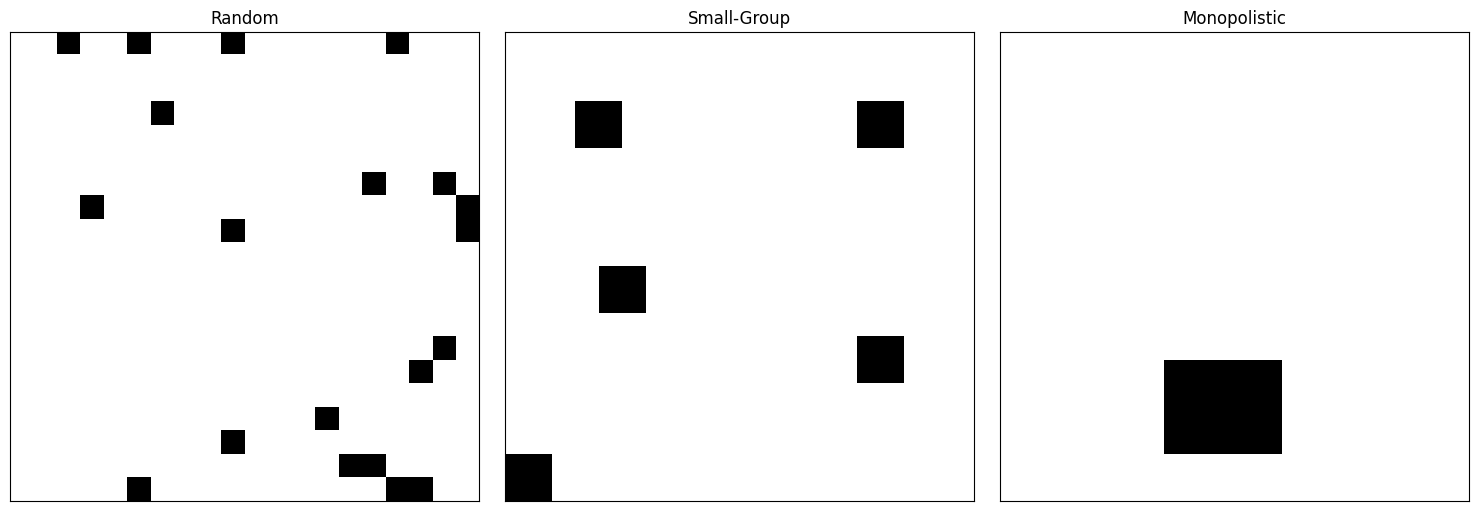

In [4]:
cellularGrid1 = set_up_configuration()   ## padrão Random
cellularGrid2 = set_up_configuration(distribution_type = 'small-group')   
cellularGrid3 = set_up_configuration(distribution_type = 'monopolistic')

tipos=['Random','Small-Group','Monopolistic']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
matriz1 = cellularGrid1.pivot(index='row', columns='col', values='status').values
matriz2 = cellularGrid2.pivot(index='row', columns='col', values='status').values
matriz3 = cellularGrid3.pivot(index='row', columns='col', values='status').values

axes[0].imshow(matriz1, cmap='binary')
axes[1].imshow(matriz2, cmap='binary')
axes[2].imshow(matriz3, cmap='binary')

# Configurar cada subplot
i = 0
for ax in axes:
    ax.grid(which='both', color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_title(f"{tipos[i]}")
    ax.set_xticks([])
    ax.set_yticks([])
    i+=1

plt.tight_layout()
plt.show()

In [5]:
def mobility(df, MD=20, IM=20, press=False):
    # Copy DataFrame to avoid modifying the original
    new_df = df.copy()

    max_row = df['row'].max()
    max_col = df['col'].max()
    rows = max_row + 1
    cols = max_col + 1

    if MD > max_row:
        MD = max_row

    columns_to_swap = [col for col in new_df.columns if col not in ['row', 'col']]
       
    # Calculate IMGrid: number of cells to swap = % da população afetada no movimento
    num_to_move = (len(df) * IM) // 100

    if MD == 0 or num_to_move == 0:
        if press:
            print("Mobilidade não aplicável (MD=0 ou IM=0). Trocas realizadas: 0")
        return new_df
    
    trocas = 0   
    # Perform swaps
    for _ in range(num_to_move):
        # Randomly select first cell (i, j)
        i = np.random.randint(0, max_row)
        j = np.random.randint(0, max_col)
        
        # Randomly select second cell (mdI, mdJ) within MDGrid 
        mdI = np.random.randint(-MD, MD+1)
        mdJ = np.random.randint(-MD, MD+1)
        while mdI == i and mdJ == j:  # Ensure different cells
            mdI = np.random.randint(-MD, MD+1)
            mdJ = np.random.randint(-MD, MD+1)

        mdI = (i + mdI) % rows # Fronteira toroidal
        mdJ = (j + mdJ) % cols # Fronteira toroidal

        # Find indices in DataFrame
        idx1 = new_df[(new_df['row'] == i) & (new_df['col'] == j)].index
        idx2 = new_df[(new_df['row'] == mdI) & (new_df['col'] == mdJ)].index
        
        if idx1.empty or idx2.empty:
            continue  # Skip if indices not found
        if idx1 == idx2:
            continue  # Skip if indices not found
        
        idx1, idx2 = idx1[0], idx2[0]    

        # Swap all attributes except row and col
        temp = new_df.loc[idx1, columns_to_swap].copy()
        new_df.loc[idx1, columns_to_swap] = new_df.loc[idx2, columns_to_swap]
        new_df.loc[idx2, columns_to_swap] = temp
        trocas += 1
    if press:
        print("Trocas realizadas: ",trocas)
        
    return new_df    

In [9]:
teste = 35
print(cellularGrid.iloc[teste])
print("------------------------------------")
df = mobility(cellularGrid,press=True)
print(df.iloc[teste])

row                    1.000000
col                   15.000000
status                 0.000000
learningCapability     0.012665
transferCapability     0.049703
forgettingRate         0.031386
quittingRate           0.025395
timesContactor         0.000000
Name: 35, dtype: float64
------------------------------------
Trocas realizadas:  80
row                    1.000000
col                   15.000000
status                 0.000000
learningCapability     0.687173
transferCapability     0.840862
forgettingRate         0.215957
quittingRate           0.222627
timesContactor         0.000000
Name: 35, dtype: float64


In [23]:
def neighborsF(df, point, radius=1, neighbors='Moore'):
    row, col = point
    neighbor_indices =[]
    rows = df['row'].max() + 1
    cols = df['col'].max() + 1   
    
    if neighbors not in ['Moore', 'VonNeumann']:
        raise ValueError("Escolha Moore ou Von Neumann")
    
    for dx in range(- radius, radius + 1):
        for dy in range(- radius, radius + 1):
            if dx == 0 and dy == 0:
                continue  # ignora a própria célula

            nx = (row + dx) % rows
            ny = (col + dy) % cols
            
            if neighbors == "VonNeumann":
                dist = abs(dx) + abs(dy)  # distância de Manhattan para validar o vizinho
                if dist <= radius:
                    dist = math.sqrt(dx**2 + dy**2) # distância Euclidiana
                    neighbor_indices.append([df[(df['row'] == nx) & (df['col'] == ny)].index,dist])

            elif neighbors == "Moore":  # Moore inclui todas as células no quadrado
                dist = math.sqrt(dx**2 + dy**2)  # distância Euclidiana
                neighbor_indices.append([df[(df['row'] == nx) & (df['col'] == ny)].index,dist])
        
    return neighbor_indices

In [24]:
# Test neighbors function
point = (10, 10)  # Center of the grid
moore_neighbors = neighborsF(cellularGrid, point, radius=1, neighbors='Moore')
von_neumann_neighbors = neighborsF(cellularGrid, point, radius=1, neighbors='VonNeumann')
result1 = [[int(item[0][0]), item[1]] for item in moore_neighbors]
print(result1)
result2 = [[int(item[0][0]), item[1]] for item in von_neumann_neighbors]
print(result2)

[[189, 1.4142135623730951], [190, 1.0], [191, 1.4142135623730951], [209, 1.0], [211, 1.0], [229, 1.4142135623730951], [230, 1.0], [231, 1.4142135623730951]]
[[190, 1.0], [209, 1.0], [211, 1.0], [230, 1.0]]


In [25]:
def acquisition_rate(df, idx_current, radius, neighbors):
    # LearningCapability do ponto atual 
    row = df.loc[idx_current, 'row']
    col = df.loc[idx_current, 'col']
    point = (row,col)
    lc_current = df.loc[idx_current, 'learningCapability']

    # Obter vizinhos com suas distâncias
    neighbor_data = neighborsF(df, point, radius=radius, neighbors=neighbors)

    max_tax = 0
    for indices, dist in neighbor_data:
        if dist == 0:
            continue
        idx = indices[0]  # índice do vizinho no DataFrame

        status_vizinho = df.loc[idx, 'status']
        if status_vizinho == 2:  # status = I
            tc_vizinho = df.loc[idx, 'transferCapability']   
            # knowledge acquisition rate
            tax = (1 / dist) * math.sqrt(lc_current * tc_vizinho)

            if tax > max_tax:
                max_tax = tax

    return max_tax

In [26]:
def apply_transition_S_to_E(df):  ## função para teste
    indx_S = df[df['status'] == 0][['row', 'col']].index
    transicoes = 0

    for i in indx_S:
        taxa = acquisition_rate(df, i, radius=1, neighbors='Moore')
        if taxa > np.random.random() :
            transicoes += 1

    print(f'Total de transições S → E realizadas: {transicoes}')

cellularGrid = set_up_configuration()  #padrão    nomalize=0.25,distribution_type='random'
apply_transition_S_to_E(cellularGrid)

Total de transições S → E realizadas: 67


In [ ]:
###### Depois que o S se tornou um E ele pode se tornar um R (forgetter) ou um Q (quitter) 
###### Em especial, o forgetter(R) continuará buscando a troca de conhecimento com o disseminator(I), podendo então se tornar um contactor (E) novamente com certas probabilidades. 
###### Além disso, como o forgetter(R) já entrou em contato com o disseminator (I) anteriormente, ele possui alguma base para o conhecimento específico.
###### Portanto, a capacidade de aprendizagem do forgetter(R) deve ser maior do que seu antigo status de susceptible (S)
###### Por outro lado, a capacidade de transferência do disseminator(I) aumenta na prática da troca de conhecimento. 
###### No entanto, o crescimento da capacidade de transferência é sempre muito lento na realidade. 
###### Portanto, supomos que a capacidade de transferência do disseminator(I) permanece inalterada durante o processo de difusão do conhecimento.        
###### Devido às diferentes capacidades de aprendizagem e absorção de conhecimento dos indivíduos e aos diferentes valores, complexidades e custos de aprendizagem do conhecimento, o contator(E) se tornará, com certas probabilidades, o disseminator(I) o forgether(R) ou o quiter(Q) no momento seguinte. As possibilidades de transição para diferentes níveis de conhecimento são indicadas pela taxa de absorção do conhecimento I, taxa de esquecimento R e taxa de desistencia Q que representa I + R + Q = 1
###### Além disso, quando um indivíduo se torna um contactor (E) repetidamente, devido ao efeito de reforço da aprendizagem, supomos que sua taxa de esquecimento (R) e desistência do conhecimento (Q) diminuirão proporcionalmente com o aumento do tempo de transição. 
###### Neste artigo, definimos a taxa de esquecimento(R) como R = R ** D + 1, portanto, a taxa de absorção do conhecimento (I) pode ser obtida como I = 1 - R ** D + 1 - Q ** D + 1 > I

###### **** Estados possíveis: 
###### knowledge susceptible  (S) = 0
###### knowledge contactor    (E) = 1
###### knowledge disseminator (I) = 2
###### knowledge forgetter    (R) = 3
###### knowledge quitter      (Q) = 4

In [27]:
def transition_F(df, radius, neighbors):
    new_df = df.copy() # cria uma cópia dos dados para promover as alterações no passo seguinte
    indices = df.index

    for idx in indices:
        status = df.loc[idx, 'status']
        D   = df.loc[idx, 'timesContactor']
        txR = df.loc[idx, 'forgettingRate']
        txQ = df.loc[idx, 'quittingRate']        

        ## Transição de S para E  
        if status == 0:
            taxa = acquisition_rate(df, idx, radius, neighbors)
            # Se encontrou pelo menos um vizinho com status 2, sortear um numero entre 0 e 1 e se for maior troca
            if taxa > np.random.random():
                new_df.at[idx, 'status'] = 1  # transita de S (0) para E (1)
                new_df.at[idx, 'timesContactor'] += 1

        ## Transição de E para I, R ou Q
        elif status == 1:
            # Ajuste com reforço de aprendizado
            Rl = txR ** (D + 1)
            Ql = txQ ** (D + 1)
            Il = 1 - Rl - Ql

            # Normalização em caso de erro numérico
            if Il < 0:
                Il = 0
                total = Rl + Ql
                Rl /= total
                Ql /= total

            # Sorteio do destino
            r = np.random.rand()
            if r < Ql:
                new_df.at[idx, 'status'] = 4  # Q - Quitter
            elif r < Ql + Rl:
                lc_current = df.loc[idx, 'learningCapability']
                new_df.at[idx, 'status'] = 3  # R - Forgetter
                new_df.at[idx, 'learningCapability'] = lc_current ** (1.0 / D)  ## incrementa a capacidade de aprendizado 
                ####### OBSERVAÇÃO: Deveria alterar a taxa ou manter a base original e incrementar ???
                ####### Será que isso pode impactar acelerando a "reaprendizagem" ???
            else:
                new_df.at[idx, 'status'] = 2  # I - Disseminator
        ## transição de R para E
        elif status == 3:         
            taxa = acquisition_rate(df, idx, radius, neighbors)
            if taxa > np.random.random():
                new_df.at[idx, 'status'] = 1  # E - Contactor
    return new_df

In [36]:
def simular_difusao(df, MD=20, IM=20, radius=1, neighbors='Moore', press=False):
    max_iter = 50
    history_stats = [] # resetar histórico

    for passo in range(1, max_iter + 1):
        status_antes = df['status'].value_counts().to_dict()

        df = transition_F(df, radius, neighbors)
        df = mobility(df,MD,IM)

        status_depois = df['status'].value_counts().to_dict()

        # Salva os dados para gerar estatísticas
        history_stats.append({
            'ciclo': passo,
            **{f'status_{s}': status_depois.get(s, 0) for s in range(5)}
        })

        if press:
            print(f'\n🌀 Ciclo {passo}')
            print(f'Estatísticas:')
            for s in range(5):
                antes = status_antes.get(s, 0)
                depois = status_depois.get(s, 0)
                print(f'  Estado {s}: {antes} → {depois}')

        if status_antes == status_depois and press:
            break
    print(f'⛔️ Simulação encerrada no passo {passo}.')
    return history_stats

In [37]:
MD = 20 # Distância máxima do salto - variações 0=nenhuma 5,10 e 20=Todo o grid 
IM = 20 # Proporção de individuos móveis - variações: 0,20%,50% e 100% 
cellularGrid = set_up_configuration()  #padrão    nomalize=0.25,distribution_type='random'
df = cellularGrid.copy()
history = simular_difusao(df, MD=MD, IM=IM, radius=1, neighbors='Moore', press=True)


🌀 Ciclo 1
Estatísticas:
  Estado 0: 380 → 303
  Estado 1: 0 → 77
  Estado 2: 20 → 20
  Estado 3: 0 → 0
  Estado 4: 0 → 0

🌀 Ciclo 2
Estatísticas:
  Estado 0: 303 → 247
  Estado 1: 77 → 56
  Estado 2: 20 → 94
  Estado 3: 0 → 1
  Estado 4: 0 → 2

🌀 Ciclo 3
Estatísticas:
  Estado 0: 247 → 112
  Estado 1: 56 → 136
  Estado 2: 94 → 148
  Estado 3: 1 → 1
  Estado 4: 2 → 3

🌀 Ciclo 4
Estatísticas:
  Estado 0: 112 → 69
  Estado 1: 136 → 44
  Estado 2: 148 → 278
  Estado 3: 1 → 3
  Estado 4: 3 → 6

🌀 Ciclo 5
Estatísticas:
  Estado 0: 69 → 31
  Estado 1: 44 → 41
  Estado 2: 278 → 321
  Estado 3: 3 → 1
  Estado 4: 6 → 6

🌀 Ciclo 6
Estatísticas:
  Estado 0: 31 → 15
  Estado 1: 41 → 17
  Estado 2: 321 → 359
  Estado 3: 1 → 0
  Estado 4: 6 → 9

🌀 Ciclo 7
Estatísticas:
  Estado 0: 15 → 10
  Estado 1: 17 → 5
  Estado 2: 359 → 375
  Estado 3: 0 → 1
  Estado 4: 9 → 9

🌀 Ciclo 8
Estatísticas:
  Estado 0: 10 → 8
  Estado 1: 5 → 3
  Estado 2: 375 → 379
  Estado 3: 1 → 0
  Estado 4: 9 → 10

🌀 Ciclo 9
Estat

In [38]:
def plot_results(results_dict, title_prefix, filename, colors=None, linestyles=None, markers=None, n_cells=400):
    """
    Função genérica para plotar os resultados de qualquer experimento.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for name, df_history in results_dict.items():
        df_history['r_t'] = df_history['status_2'] / n_cells
        df_history['v_t'] = df_history['status_2'].diff().fillna(0)
        ax1.plot(df_history['ciclo'], df_history['r_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name) if linestyles else '-', marker='o', markersize=3)
        ax2.plot(df_history['ciclo'], df_history['v_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name, '--') if linestyles else '--', marker='x', markersize=4)
    ax1.set_title('(a) Proporção de Disseminadores vs. Tempo')
    ax1.set_xlabel('Ciclos de Tempo')
    ax1.set_ylabel('Proporção de Disseminadores ($r_t$)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.set_ylim(0, 1.05)
    ax1.set_xlim(0, 50)
    ax2.set_title('(b) Velocidade de Difusão vs. Tempo')
    ax2.set_xlabel('Ciclos de Tempo')
    ax2.set_ylabel('Novos Disseminadores ($v_t$)')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.set_xlim(0, 50)
    fig.suptitle(title_prefix, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=300)
    print(f"Gráficos salvos com sucesso no arquivo '{filename}'")
    plt.close(fig)

In [47]:
# --- FUNÇÕES DE EXECUÇÃO DOS EXPERIMENTOS ---
def run_experiment_figure_4(MD=0,IM=0,normalize=(0,0.25),radius=1,neighbors='Moore'):
    """Executa as simulações para replicar a Figura 4."""
    print("\n--- Iniciando simulações para a Figura 4: Impacto da Distribuição Inicial ---")
    scenarios = ['random', 'small-group', 'monopolistic']
    results = {}
    for scenario in scenarios:
        print(f"  Executando cenário: {scenario.capitalize()}...")
        initial_grid = set_up_configuration(normalize=normalize,distribution_type=scenario)  
        history = simular_difusao(initial_grid, MD=MD, IM=IM, radius=radius
                                 ,neighbors=neighbors, press=False)
        results[scenario.capitalize()] = pd.DataFrame(history)
    plot_results(results,
                 'Impacto da Distribuição Inicial dos Disseminadores',
                 'figura_4_simulacao.png',
                 colors={'Random': 'green', 'Small-group': 'orange', 'Monopolistic': 'blue'},
                 linestyles={'Random': '-', 'Small-group': '--', 'Monopolistic': ':'})

def run_experiment_figure_5(MD=0,IM=0,normalize=(0,0.25)):
    """Executa as simulações para replicar a Figura 5."""
    print("\n--- Iniciando simulações para a Figura 5: Impacto da Vizinhança ---")
    scenarios = {
        '1x1 Von Neumann': {'radius': 1, 'type': 'VonNeumann'},
        '1x1 Moore':       {'radius': 1, 'type': 'Moore'},
        '2x2 Von Neumann': {'radius': 2, 'type': 'VonNeumann'},
        '2x2 Moore':       {'radius': 2, 'type': 'Moore'}
    }
    results = {}
    np.random.seed(42)
    initial_grid = set_up_configuration(normalize=normalize,distribution_type='random')  
    for name, params in scenarios.items():
        print(f"  Executando cenário: {name}...")
        history = simular_difusao(initial_grid.copy(), MD=MD, IM=IM,
                                  radius=params['radius'], neighbors=params['type'], press=False)
        results[name] = pd.DataFrame(history)
    plot_results(results,
                 'Impacto da Acessibilidade ao Conhecimento (Vizinhança)',
                 'figura_5_simulacao.png')

def run_experiment_figure_6(MD=5,normalize=(0,0.25),radius=1):
    """Executa as simulações para replicar a Figura 6 (Impacto da Proporção de Indivíduos Móveis)."""
    print("\n--- Iniciando simulações para a Figura 6: Impacto da Proporção de Móveis (IM) ---")
    scenarios = [0, 20, 50, 100]
    results = {}
    np.random.seed(43)
    initial_grid = set_up_configuration(normalize=normalize,distribution_type='random')  
    for im_percent in scenarios:
        name = f'IM = {im_percent}%'
        print(f"  Executando cenário: {name}...")
        history = simular_difusao(initial_grid.copy(), MD=MD, IM=im_percent, radius=radius
                                 ,neighbors='VonNeumann', press=False)
        results[name] = pd.DataFrame(history)
    plot_results(results,
                 'Impacto da Proporção de Indivíduos Móveis (IM)',
                 'figura_6_simulacao.png')

def run_experiment_figure_7(IM=20,normalize=(0,0.25),radius=1):
    """Executa as simulações para replicar a Figura 7 (Impacto da Distância Máxima de Movimento)."""
    print("\n--- Iniciando simulações para a Figura 7: Impacto da Distância de Movimento (MD) ---")
    scenarios = [0, 5, 10, 20]
    results = {}
    np.random.seed(44)
    initial_grid = set_up_configuration(normalize=normalize,distribution_type='random')  
    for md_dist in scenarios:
        name = f'MD = {md_dist}'
        print(f"  Executando cenário: {name}...")
        history = simular_difusao(initial_grid.copy(), 
                                  MD=md_dist, IM=IM,
                                  radius=radius, neighbors='VonNeumann', press=False)
        results[name] = pd.DataFrame(history)
    plot_results(results,
                 'Impacto da Distância Máxima de Movimento (MD)',
                 'figura_7_simulacao.png')

def run_experiment_figure_8(MD=0,IM=0,radius=1):
    """Executa as simulações para replicar a Figura 8 (Impacto da Taxa de Desistência)."""
    print("\n--- Iniciando simulações para a Figura 8: Impacto da Taxa de Desistência ---")
    # Interpretando a notação N(a,b) do artigo como uma distribuição Uniforme(a,b)
    scenarios = {
        'Taxa [0-0.25]':    {'min': 0.0, 'max': 0.25},
        'Taxa [0.25-0.5]':  {'min': 0.25, 'max': 0.50},
        'Taxa [0.5-0.75]':  {'min': 0.50, 'max': 0.75},
        'Taxa [0.75-1.0]':  {'min': 0.75, 'max': 1.0} # Corrigindo o provável typo do artigo N(0.75, 0.10)
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cenário: {name}...")
        np.random.seed(45)
        initial_grid = set_up_configuration(normalize=(params['min'],params['max']),distribution_type='random')
        history = simular_difusao(initial_grid.copy(), MD=MD, IM=IM,
                                  radius=radius, neighbors='Moore', press=False)
        results[name] = pd.DataFrame(history)
    plot_results(results,
                 'Impacto da Taxa de Desistência do Conhecimento',
                 'figura_8_simulacao.png')

In [50]:
run_experiment_figure_4()
run_experiment_figure_5()
run_experiment_figure_6()
run_experiment_figure_7()
run_experiment_figure_8()

print("\nTodos os experimentos foram concluídos com sucesso.")


--- Iniciando simulações para a Figura 4: Impacto da Distribuição Inicial ---
  Executando cenário: Random...
⛔️ Simulação encerrada no passo 50.
  Executando cenário: Small-group...
⛔️ Simulação encerrada no passo 50.
  Executando cenário: Monopolistic...
⛔️ Simulação encerrada no passo 50.
Gráficos salvos com sucesso no arquivo 'figura_4_simulacao.png'

--- Iniciando simulações para a Figura 5: Impacto da Vizinhança ---
  Executando cenário: 1x1 Von Neumann...
⛔️ Simulação encerrada no passo 50.
  Executando cenário: 1x1 Moore...
⛔️ Simulação encerrada no passo 50.
  Executando cenário: 2x2 Von Neumann...
⛔️ Simulação encerrada no passo 50.
  Executando cenário: 2x2 Moore...
⛔️ Simulação encerrada no passo 50.
Gráficos salvos com sucesso no arquivo 'figura_5_simulacao.png'

--- Iniciando simulações para a Figura 6: Impacto da Proporção de Móveis (IM) ---
  Executando cenário: IM = 0%...
⛔️ Simulação encerrada no passo 50.
  Executando cenário: IM = 20%...
⛔️ Simulação encerrada no p